# Figure 7: Gene Expression

In [1]:
#----------------------------------------------------------
# Import Libraries
#----------------------------------------------------------
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp
sns.set()

#Set the background and size of the figure
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.edgecolor': 'black', 'font.family': 'Arial'})
my_pal = {"Control Ad Lib": "gray", "HFHS Ad Lib": "red", "Control Restricted": "white", "HFHS Restricted": "white"}
plt.rcParams['hatch.linewidth'] = 3
plt.rcParams['figure.dpi'] = 1000

## Download gene data

Download metafile data with the group description

In [2]:
metafile_location = "https://www.dropbox.com/s/37toe3vct1pipn5/groups.csv?dl=1"
metafile = pd.read_csv(metafile_location, index_col=0)
metafile['group']=metafile.diet+' '+metafile.feeding
metafile.head()

,diet,feeding,group
Rat,,,
1,control,ad lib,control ad lib
2,control,ad lib,control ad lib
3,control,ad lib,control ad lib
4,control,ad lib,control ad lib
5,control,ad lib,control ad lib


Get the data using dropbox link. Extract the gene names using column heading and save them in **gene list**

In [3]:
gene_data_location = "https://www.dropbox.com/s/rxjk6bjw2fpa3m1/qPCR_normalized_gapdph.csv?dl=1"
gene_data = pd.read_csv(gene_data_location, index_col=0)

# Rearrange so that Oxtr is the last gene column
col_list = list(gene_data)
col_list[11], col_list[8] = col_list[8], col_list[11]
gene_data = gene_data.loc[:,col_list]


gene_list = gene_data.columns.unique()
# Remove outliers, that is the measurments which is larger than 7
for c in gene_list:
    # Find index of an outlier and replace it with NAN
    out_ind = gene_data[c][gene_data[c]>=7].index
    gene_data[c][out_ind ]=np.NaN
# Add experimental group as a column to the gene dataset
ids_in_gene_data = gene_data.index
gene_data['group'] = metafile.group.loc[ids_in_gene_data]
gene_data['diet'] = metafile.diet.loc[ids_in_gene_data]
gene_data['feeding_schedule'] = metafile.feeding.loc[ids_in_gene_data]



gene_data.head()

,CART,NPY,AgRP,GLP1R,Npy2R,Ghsr,Insr,Lepr,MC4R,Cckar,Cckbr,Oxtr,group,diet,feeding_schedule
2,1.369340,0.748760,2.161361,1.297956,1.560879,4.597757,1.468209,1.883721,0.820854,1.990703,1.074096,1.611840,control ad lib,control,ad lib
6,1.669095,0.670232,1.381644,2.179846,3.612036,2.853085,1.652634,2.870864,4.686374,2.871240,4.289009,1.493576,control ad lib,control,ad lib
7,1.430304,1.504685,1.663850,2.070428,3.752371,2.621707,1.534294,2.275886,1.668385,4.892259,2.609463,2.664512,control ad lib,control,ad lib
3,0.450856,1.787492,0.688038,0.864752,1.325854,0.425616,1.204578,0.918813,3.339488,2.791819,3.417703,1.214725,control ad lib,control,ad lib
4,1.267757,0.936041,0.497659,1.092165,0.968283,1.218026,1.067142,1.467878,1.494192,4.658525,2.171984,0.946401,control ad lib,control,ad lib


In [9]:
gene_data.sort_index().index

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20,
            21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
           dtype='int64')

## PLot  individual genes as boxplots

Download file with plotting parameters

In [4]:
plot_data_location = "https://www.dropbox.com/s/djpbvky0mwxpups/plotting_by_group.csv?dl=1"
plot_parameters = pd.read_csv(plot_data_location, index_col=0)
plot_parameters

,color,marker,line_type,hatches,hatch_colors,fill_color,label
group,,,,,,,
control ad lib,grey,o,-,,grey,grey,CA
control restriction,grey,v,--,/,grey,white,CR
HFHS ad lib,red,o,-,,red,red,HA
HFHS restriction,red,v,--,/,red,white,HR


Make a function for individual gene plot

In [46]:
def make_graph(data, plot_parameters, name):
    #ax1 = sns.swarmplot(x=data.group, y=data[name], color='black', size=6)
    ax = sns.boxplot   (x=data.group, y=data[name], color='white', linewidth=1, palette=plot_parameters.fill_color, showfliers = False)
    # Make hatched pattern to distinguish between Ad lib and restriction
    for i, hatch, patch in zip(plot_parameters.hatch_colors, plot_parameters.hatches, ax.artists):
        patch.set_hatch(hatch)
        patch.set_edgecolor(i)
    # Add x- and y-labels, ticks, and units    
    plt.xlabel('')
    plt.ylabel(c.capitalize(), fontstyle = "italic", fontsize = "x-large")
    ax.xaxis.set_major_formatter(plt.NullFormatter())

Make a custom legend

In [47]:
def make_legend():
    a_val = 0.6
    colors = ['gray','none','red','none']

    circ1 = mpatches.Patch(facecolor=colors[0],hatch='',label='Cont AL')
    circ2 = mpatches.Patch(facecolor=colors[1],hatch='//', edgecolor = "gray", label='Cont Res')
    circ3 = mpatches.Patch(facecolor=colors[2],hatch='',label='HFHS AL')
    circ4 = mpatches.Patch(facecolor=colors[3],hatch='//', edgecolor = "red", label='HFHS Res')

    plt.legend(handles = [circ1,circ2,circ3, circ4],loc="upper left", bbox_to_anchor=[0, 1], shadow = True, 
              fancybox = True, borderaxespad=0., prop={'size': 15})
    # plt.tight_layout()
    return()

## Loop though gene names to plot barplot for experimetnal conditions

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Ad

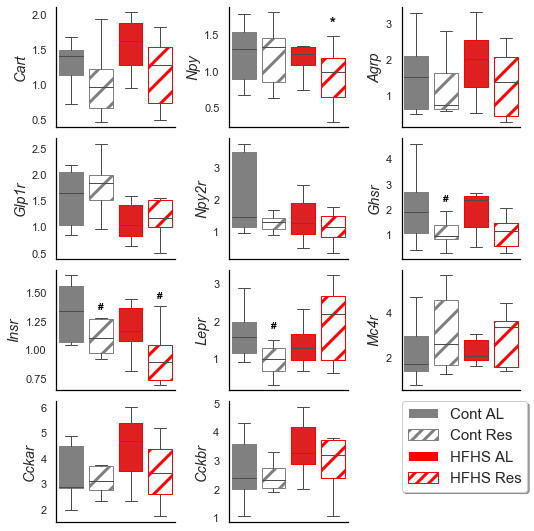

In [48]:
plt.figure(figsize = (7.48,7.48))
plt.subplots_adjust(wspace = 0.3 )
subplot_n=1
for c in gene_list[:-1]:
    plt.subplot(4,3,subplot_n)
    make_graph(gene_data, plot_parameters, c)   
    subplot_n = subplot_n+1 
    

### Designate the last subplot for the legend
ax = plt.subplot(4,3,subplot_n)
# Remove the x- and y-ticks
plt.xticks([])
plt.yticks([])
# Remove the x- and y-axis lines
ax.set_frame_on(False)
make_legend()

# NPY
plt.subplot(4,3,2)
plt.annotate('*', (2.9, 1.6), fontsize=15, color = 'black', fontweight='bold')

# Ghsr
plt.subplot(4,3,6)
plt.annotate('#', (0.9, 2.3), fontsize=10, color = 'black', fontweight='bold')

# Insr
plt.subplot(4,3,7)
plt.annotate('#', (0.9, 1.35), fontsize=10, color = 'black', fontweight='bold')
plt.annotate('#', (2.9, 1.45), fontsize=10, color = 'black', fontweight='bold')

# Lepr
plt.subplot(4,3,8)
plt.annotate('#', (0.9, 1.8), fontsize=10, color = 'black', fontweight='bold')

sns.despine()
plt.tight_layout()
plt.savefig('Figure7.tiff', dpi = 1000)
plt.show()